
# 🧠 LSTM Player and Ball Movement Prediction

This notebook:
- Loads your cleaned CSV file of 20 frames
- Parses and flattens [x; y] positions
- Normalizes all coordinates
- Trains an LSTM model on sequences of 10 frames
- Predicts 4 full frames (frames 17–20)
- Denormalizes predictions
- Compares predicted vs actual positions


In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:

def parse_coords(cell):
    if isinstance(cell, str) and (';' in cell or ',' in cell):
        cell = cell.strip('[]')
        sep = ';' if ';' in cell else ','
        try:
            coords = [float(x) for x in cell.split(sep)]
            # Convert from cm to m
            return [x / 100.0 for x in coords]
        except ValueError:
            return np.nan
    return np.nan

# Load CSV
df = pd.read_csv("subset1_cleaned_new.csv")

# Convert string coordinates like "[123;456]" to [123.0, 456.0]
def parse_coords(cell):
    if isinstance(cell, str) and (';' in cell or ',' in cell):
        cell = cell.strip('[]')
        sep = ';' if ';' in cell else ','
        try:
            return [float(x) for x in cell.split(sep)]
        except ValueError:
            return np.nan
    return np.nan

parsed_df = df.drop(columns=['frame_index']).applymap(parse_coords)

# Drop poorly filled columns, then fill remaining NaNs
parsed_df = parsed_df.loc[:, parsed_df.notna().mean() >= 0.8]
parsed_df = parsed_df.fillna(method='ffill').fillna(method='bfill')

# Flatten to [x1, y1, x2, y2, ..., xN, yN]
flattened_data = np.array([
    np.concatenate(row) for row in parsed_df.values
])
flattened_data.shape

<ipython-input-3-e43a8d2491c2>:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  parsed_df = df.drop(columns=['frame_index']).applymap(parse_coords)
<ipython-input-3-e43a8d2491c2>:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  parsed_df = parsed_df.fillna(method='ffill').fillna(method='bfill')


(22, 32)

In [ ]:

# Normalize data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(flattened_data)

# Sanity check
normalized_data[:2]


array([[0.98279945, 0.6733643 , 0.83814348, 0.        , 0.70666112,
        0.        , 0.6659022 , 0.        , 0.        , 0.        ,
        0.46673945, 0.        , 0.22273327, 0.        , 0.99492584,
        0.        , 0.49882478, 0.        , 0.52722803, 0.        ,
        0.9936382 , 0.        , 0.63399704, 0.        , 0.87871633,
        0.        , 0.2798845 , 0.        , 1.        , 0.82620686,
        0.84047004, 0.        ],
       [0.98886132, 0.76298718, 0.85608808, 0.0257455 , 0.71547322,
        0.04522829, 0.69721893, 0.05463664, 0.11473242, 0.01184848,
        0.51701423, 0.00907133, 0.32185597, 0.10863534, 0.98524168,
        0.15459587, 0.58065123, 0.04173716, 0.57254506, 0.05667859,
        0.99651003, 0.16287346, 0.67058702, 0.0072022 , 0.89640052,
        0.04673661, 0.38944498, 0.0173482 , 0.98326748, 0.84664286,
        0.84102375, 0.03439724]])

In [ ]:

# Prepare training data: sequences of 10 to predict next
X_train, y_train = [], []
for i in range(6):  # frames 1–6 to predict 11–16
    X_train.append(normalized_data[i:i+10])
    y_train.append(normalized_data[i+10])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Initial input for recursive prediction
X_test_start = normalized_data[6:16]


In [ ]:

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(10, X_train.shape[2]), return_sequences=False),
    Dense(X_train.shape[2])
])
model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

# Predict 4 frames recursively
predictions = []
input_seq = X_test_start.copy()

for _ in range(4):  # predict frames 17–20
    pred = model.predict(input_seq[np.newaxis, ...], verbose=0)[0]
    predictions.append(pred)
    input_seq = np.vstack([input_seq[1:], pred])

# Denormalize predictions
predictions = scaler.inverse_transform(np.array(predictions))

# Actual frames 17–20 for comparison
actual = flattened_data[16:20]


In [ ]:

# Compare predictions to actual for all entities
for i in range(4):
    print(f"Frame {17+i}:")
    print("  Predicted:", predictions[i].reshape(-1, 2))
    print("  Actual:   ", actual[i].reshape(-1, 2))
    print()


Frame 17:
  Predicted: [[5770.239  6459.11  ]
 [7275.9165 4760.069 ]
 [6049.8853 6099.26  ]
 [8455.813  4043.7236]
 [6557.8438 5929.7173]
 [8368.029  4927.172 ]
 [6903.49   6055.424 ]
 [7793.236  6322.0728]
 [7402.781  3433.8308]
 [8164.285  4384.865 ]
 [5363.319  6337.2705]
 [5751.3794 4599.686 ]
 [5316.446  4662.0884]
 [8377.596  3380.2322]
 [6314.015  6705.705 ]
 [6865.353  4049.7898]]
  Actual:    [[5761.85 6455.4 ]
 [7286.85 4817.64]
 [6053.85 6121.72]
 [8455.89 4052.72]
 [6585.7  6007.38]
 [8401.48 4965.51]
 [6904.75 6064.61]
 [7787.77 6330.93]
 [7384.59 3461.97]
 [8186.33 4442.92]
 [5301.5  6370.03]
 [5775.18 4663.74]
 [5302.65 4725.78]
 [8376.09 3424.43]
 [6314.1  6741.88]
 [6897.33 4110.71]]

Frame 18:
  Predicted: [[5639.196  6379.409 ]
 [7241.362  4737.812 ]
 [5988.676  6107.1553]
 [8442.872  4038.0872]
 [6546.948  5898.8335]
 [8335.953  4929.675 ]
 [6892.476  6040.543 ]
 [7754.0728 6280.5137]
 [7389.9297 3444.243 ]
 [8148.8394 4361.6865]
 [5351.925  6338.777 ]
 [5733.982  4

In [ ]:

# Save predictions to CSV for external use
pred_df = pd.DataFrame(predictions, columns=parsed_df.columns.repeat(2) + ['_x', '_y'] * (predictions.shape[1] // 2))
pred_df.to_csv("predicted_frames_17_to_20.csv", index=False)
files.download("predicted_frames_17_to_20.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

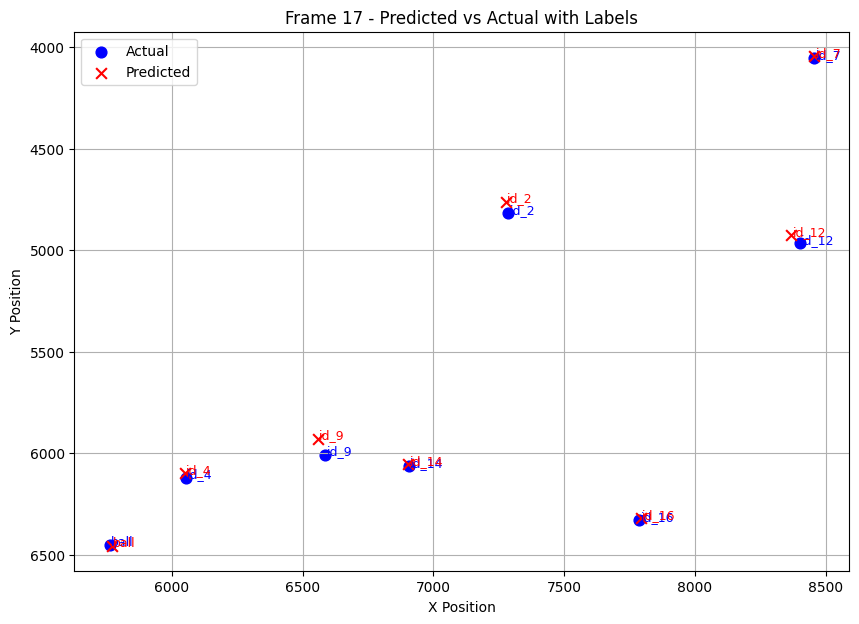

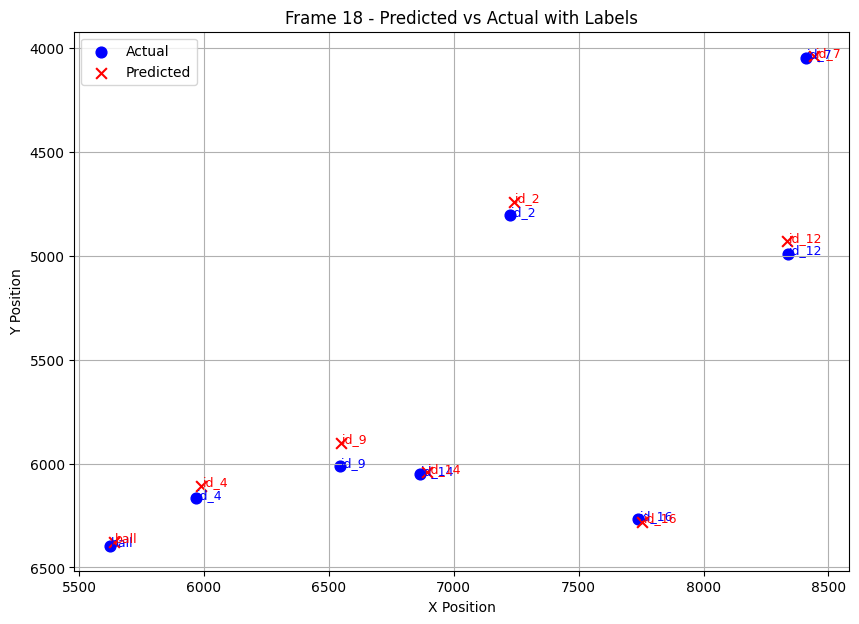

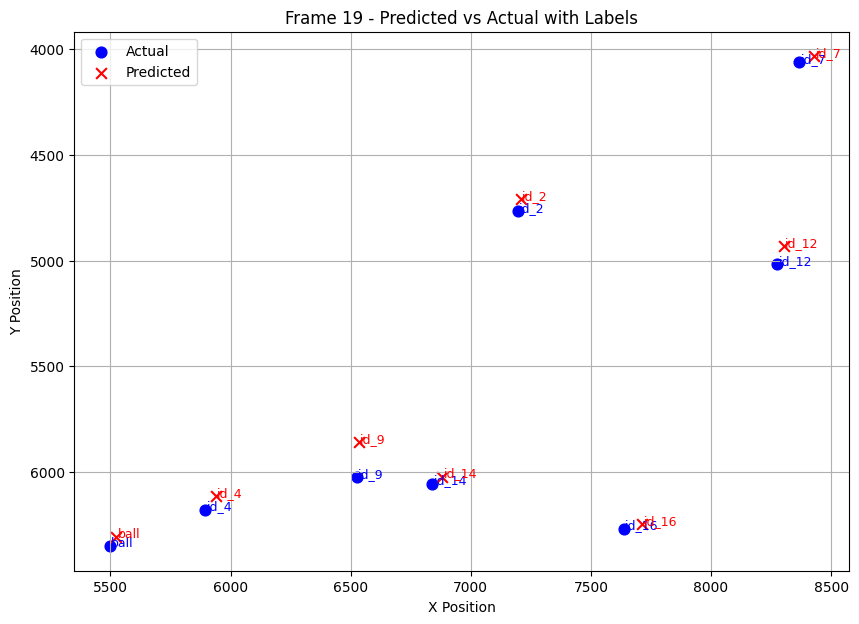

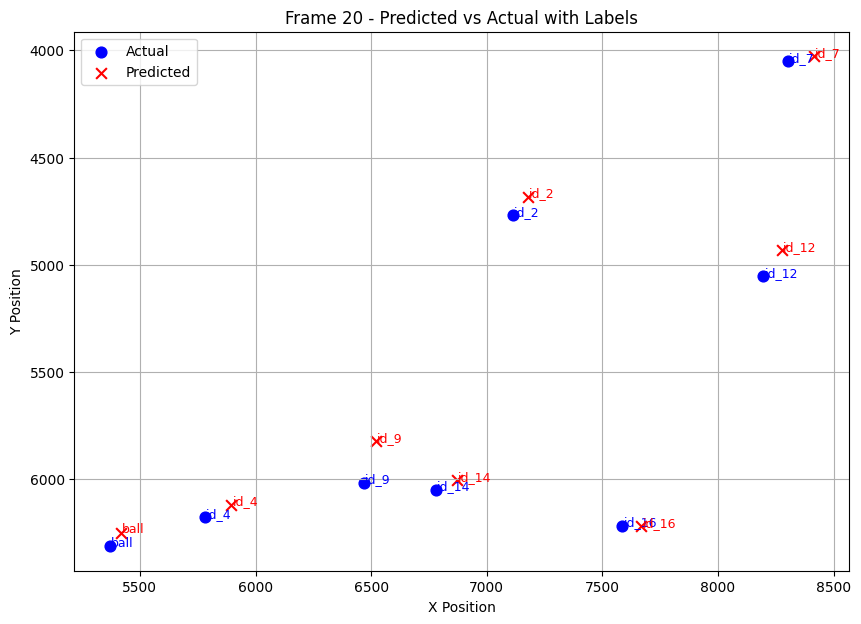

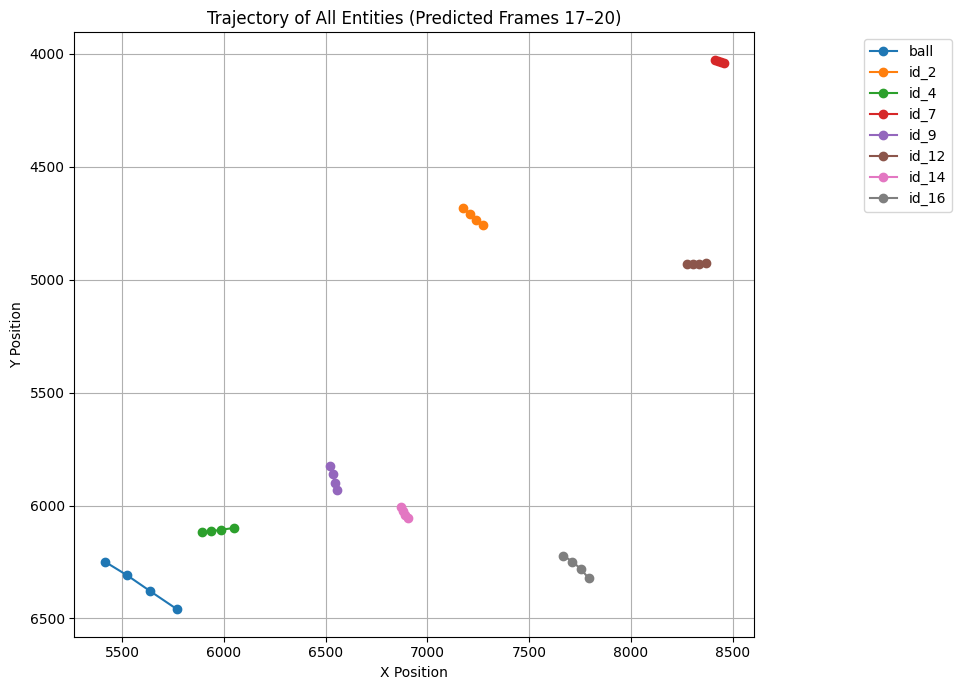

In [ ]:

import matplotlib.pyplot as plt

# Use entity names from columns (player/ball labels)
entity_names = [col.replace("_x", "") for col in parsed_df.columns[::2]]

# Per-frame comparison plots with labels
for i in range(4):  # frames 17–20
    plt.figure(figsize=(10, 7))
    actual_pts = actual[i].reshape(-1, 2)
    pred_pts = predictions[i].reshape(-1, 2)

    for j in range(len(entity_names)):
        ax, ay = actual_pts[j]
        px, py = pred_pts[j]
        plt.scatter(ax, ay, color='blue', label='Actual' if j == 0 else "", s=60)
        plt.scatter(px, py, color='red', marker='x', label='Predicted' if j == 0 else "", s=60)
        plt.text(ax+5, ay, f"{entity_names[j]}", fontsize=9, color='blue')
        plt.text(px+5, py, f"{entity_names[j]}", fontsize=9, color='red')

    plt.title(f"Frame {17+i} - Predicted vs Actual with Labels")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

# --- Final graph: show trajectories for all entities over 4 predicted frames ---
plt.figure(figsize=(10, 7))
for j in range(len(entity_names)):
    traj = predictions[:, j*2:j*2+2]  # x, y over 4 frames
    plt.plot(traj[:, 0], traj[:, 1], marker='o', label=entity_names[j])

plt.title("Trajectory of All Entities (Predicted Frames 17–20)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
